In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [17]:
data = np.loadtxt(open('../00-Dataset/mnist_train_small.csv', 'rb'), delimiter=',')

In [18]:
data.shape
labels = data[:,0]
data = data[:,1:]


In [19]:
# normalize the data to a range of [0, 1]
dataNorm = data/np.max(data)

In [67]:
dataNorm.shape

(20000, 784)

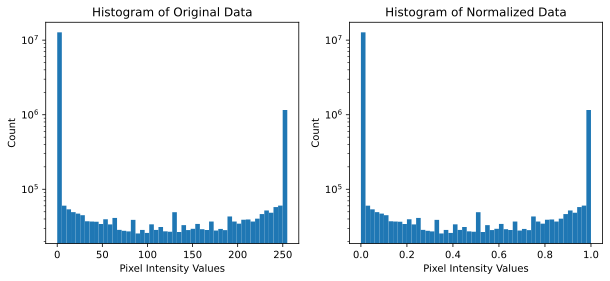

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of Original Data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Normalized Data')
ax[1].set_yscale('log')
plt.show()

In [49]:
# convert data to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, train_size = 0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__())


In [39]:
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchSize           int              32
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
dataloader          module           <module 'torch.utils.data<...>tils/data/dataloader.py'>
fig                 Figure           Figure(1000x400)
labels              ndarray          20000: 20000 elems, typ

In [40]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(784, 64)
        self.h1 = nn.Linear(64, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 10)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = torch.log_softmax(self.output(x), axis=1)
        # log_softmax() because of NLLLoss instead of CrossEntropyLoss

        return x

In [41]:
def getModel():
    ANN = Model()
    lossFunction = nn.NLLLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    return ANN, lossFunction, optimizer

In [45]:
# test above function/class
ANN, lossFunction, optimizer = getModel()

X, y = next(iter(train_loader))

yHat = ANN(X)
print(yHat) # these are the log of probabilities that the model outputs. Log, beacuse of log_softmax()
print(torch.exp(yHat)) # undoing the log. These will be between 0 and 1



tensor([[-2.4451, -2.2873, -2.3108, -2.3548, -2.3497, -2.2141, -2.0491, -2.4468,
         -2.1784, -2.4726],
        [-2.4643, -2.2650, -2.3121, -2.3508, -2.3502, -2.2192, -2.0534, -2.4410,
         -2.1661, -2.4923],
        [-2.4525, -2.2812, -2.3100, -2.3565, -2.3454, -2.2176, -2.0473, -2.4461,
         -2.1748, -2.4803],
        [-2.4493, -2.2916, -2.3136, -2.3587, -2.3420, -2.1970, -2.0627, -2.4356,
         -2.1809, -2.4744],
        [-2.4720, -2.2855, -2.3152, -2.3494, -2.3373, -2.2169, -2.0460, -2.4411,
         -2.1599, -2.4950],
        [-2.4591, -2.2847, -2.3113, -2.3686, -2.3395, -2.2050, -2.0545, -2.4466,
         -2.1732, -2.4679],
        [-2.4588, -2.2763, -2.3109, -2.3480, -2.3432, -2.2115, -2.0557, -2.4427,
         -2.1738, -2.4909],
        [-2.4562, -2.2674, -2.3130, -2.3507, -2.3459, -2.2226, -2.0411, -2.4652,
         -2.1664, -2.4909],
        [-2.4684, -2.3002, -2.3058, -2.3546, -2.3432, -2.2200, -2.0421, -2.4383,
         -2.1644, -2.4779],
        [-2.4625, -

In [80]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 60

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1)==y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [81]:
ANN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

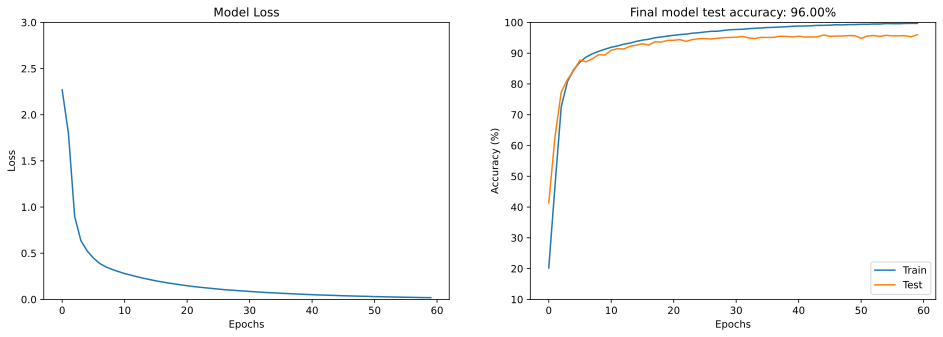

In [83]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')
ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Inspect the result in more details

In [86]:
X, Y = next(iter(test_loader))

with torch.no_grad():
    predictions = ANN(X).detach()

predictions

tensor([[-1.0956e+01, -2.9737e+01, -8.7001e+00,  ..., -2.3510e+01,
         -3.4077e+01, -4.3292e+01],
        [-1.8120e+01, -1.9812e+01, -1.8707e+01,  ..., -1.9967e-03,
         -2.0501e+01, -6.2185e+00],
        [-1.8111e+01, -2.3312e+01, -2.6668e+01,  ..., -1.8659e+01,
         -8.6014e+00, -4.1798e-04],
        ...,
        [-1.5499e+01, -7.4182e+00, -1.4215e+01,  ..., -2.7349e+00,
         -9.7634e+00, -7.2083e-02],
        [-1.1014e+01, -2.0740e+01, -9.5164e+00,  ..., -2.0258e+01,
         -2.1980e+01, -3.1198e+01],
        [-1.8715e+01, -2.1268e+01, -2.2468e+01,  ..., -1.6308e+01,
         -1.3374e+01, -7.0212e-05]])

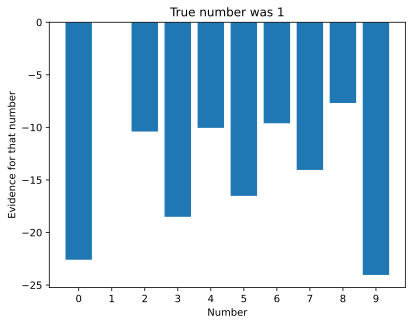

In [91]:
sample2test = 122
plt.bar(range(10), predictions[sample2test])
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %Y[sample2test].item())
plt.show()

# log of 1 is 0 so the correct prob is close to zero

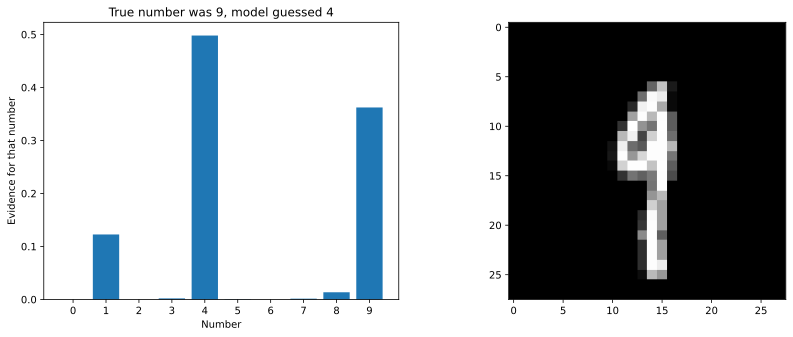

In [114]:
# find the errors

errors = np.where(torch.argmax(predictions, axis=1)!=Y)[0]

sample2test = 29

fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2test]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number was %s, model guessed %s' %(Y[errors[sample2test]].item(), 
                torch.argmax(predictions[errors[sample2test]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2test],:], (28, 28)), cmap = 'gray')
plt.show()